# Detecting Mental Clues Remotely - Working Paper
by Ivan Liu, Fangyuan Liu, Qi Zhong, Shiguang Ni 

## Figure 4 and 5

In [2]:
#Commonly Used Packages
import sys
sys.path.insert(0, sys.path[0]+"/../")
import mmer.utility.preprocessing
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import mmer.utility.preprocessing
import seaborn as sns
from scipy.stats import ttest_ind, ttest_rel, ttest_1samp
import statsmodels.formula.api as smf

In [3]:
plt.rcParams['axes.unicode_minus'] = False    # Show minus or not
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

#ROI List
index_list = [18, 25, 21, 22, 58, 28, 29, 30, 32, 34, 49, 52, 53, 51, 48, 50, 55, 57, 54, 56, 59, 60]
point_RR_index = [str(ind)+"_std" for ind in index_list]
point_mean_index = [str(ind)+"_mean" for ind in index_list]
point_difference_index = [str(ind)+"_difference" for ind in index_list]

ratio_index = ["{}/54".format(ind) for ind in index_list]
ratio_diff_index = [ind+"_difference" for ind in ratio_index]

In [4]:
def compute_ratio(df):
    df_point = df[df["use"] == 1]  # 这句其实已经没什么用处了
    df_point = df_point.loc[:, point_RR_index+point_mean_index]

    # Remove outliers
    df_point_outlier = get_outliers(df_point, point_RR_index, RR=True, k=1.5)
    df_point_outlier = get_outliers(df_point_outlier, point_mean_index, RR=False, k=1.5)
    # df_point_outlier = get_outliers(df_point_outlier, point_RR_index, RR=True, k=1.5)

    # Update results to DataFrame
    df.loc[:, point_RR_index+point_mean_index] = np.nan  # Make the columns empty
    df.loc[:, point_RR_index+point_mean_index] = df_point_outlier # Fill in data without outliers
    useful_index = df_point.index
    df.loc[useful_index, point_difference_index] = np.nan  # Make the columns empty

    # 计算同一个人同一个点的结束/开始
    ref_list = df.loc[useful_index, "No-Step"].tolist()
    for row in useful_index:
        no_step = "-".join(df.loc[row, "No-Step"].split("-")[:-1])

        if no_step+"-0" in ref_list:
            start = 0
        else:
            start = -1

        temp_list = []
        for ind in range(0, 20):
            if no_step+"-"+str(ind) in ref_list:
                temp_list.append(ind)
        end = max(temp_list)

        if end > start > -1:  # 说明有戏
            end_index = df[df["No-Step"] == no_step+"-"+str(end)].index[0]  # 如果有多个重复行，取第一个的下标
            start_index = df[df["No-Step"] == no_step+"-"+str(start)].index[0]  # 如果有多个重复行，取第一个的下标
            # df.loc[row, point_difference_index] = (100*(df.loc[end_index, point_mean_index]/df.loc[start_index, point_mean_index]).astype('float').apply(np.log10)).copy().values.tolist()
            df.loc[row, point_difference_index] = (df.loc[end_index, point_mean_index] - df.loc[start_index, point_mean_index]).copy().values.tolist()

    return df

In [5]:
def single_ROI(df_seq0):
    single_ROI_t_test = {}
    rel_t_test_results = {}
    value_list = []
    color_list = []
    color_21_list = []
    color_11_list = []
    value_21_list = []
    value_11_list = []

    for i in index_list:
        group_21 = df_seq0[df_seq0["Step-new"] == group_1]["{}_difference".format(i)].dropna().tolist()
        group_11 = df_seq0[df_seq0["Step-new"] == group_2]["{}_difference".format(i)].dropna().tolist()

        single_ROI_t_test["{}_difference".format(i)] = ttest_ind(group_21, group_11)
        # single_ROI_t_test["{}_difference".format(i)] = ttest_rel(group_21, group_11)
        avg_diff = np.mean(group_21)-np.mean(group_11)

        value_21_list.append(np.mean(group_21))
        value_11_list.append(np.mean(group_11))
        value_list.append(avg_diff)
        color_21_list.append(ttest_1samp(group_21, 0).pvalue)
        color_11_list.append(ttest_1samp(group_11, 0).pvalue)
        color_list.append(single_ROI_t_test["{}_difference".format(i)].pvalue)
        # color_list.append(rel_t_test_results["{}_difference".format(i)].pvalue)
        # print("{}_difference\t{}\t{}".format(i, round(avg_diff, 3), round(single_ROI_t_test["{}_difference".format(i)].pvalue, 3)))

    # value_array = np.array([value_21_list, value_11_list, value_list])
    value_array = np.array([color_21_list, color_11_list, color_list])
    color_array = np.array([color_21_list, color_11_list, color_list])

    plt.xticks(np.arange(len(index_list)), labels=index_list, fontsize=8)
    plt.yticks(np.arange(3), labels=[str(group_1)+"_mean", str(group_2)+"_mean", "{}-{} difference".format(group_1, group_2)], fontsize=8)

    for i in range(3):
        for j in range(len(index_list)):
            if color_array[i, j] >= 0.05:
                color = "black"
            else:
                color = "white"
            text = plt.text(j, i, round(value_array[i, j], 3), ha="center", va="center", color=color, fontsize=4)

    top = mpl.colormaps['YlOrRd_r']
    bottom = mpl.colormaps['YlGn_r']  # YlGn_r
    newcolors = np.vstack((top(np.linspace(0, 1, 5 * 5 * 2)[: 25]),
                           bottom(np.linspace(0, 1, 95 * 5 * 2)[95 * 5:])))
    newcmp = ListedColormap(newcolors, name="OrangeBlue")
    plt.imshow(color_array, vmin=0, vmax=1, cmap=newcmp)
    # plt.colorbar()
    plt.tight_layout()

    plt.savefig("single_ROI.png", dpi=450)
    plt.show()

In [8]:
def draw_heatmap(df_seq0):
    t_test_results = {}
    rel_t_test_results = {}
    diff_diff_list = []
    for i in index_list:
        for j in index_list:
            df_seq0.loc[:, "{}-{}_diff".format(i, j)] = df_seq0.loc[:, "{}_difference".format(i)]-df_seq0.loc[:, "{}_difference".format(j)].copy().values.tolist()
            # df_seq0.loc[:, "{}-{}_diff".format(i, j)] = (100*(df_seq0.loc[:, "{}_difference".format(i)]/df_seq0.loc[:, "{}_difference".format(j)]).apply(np.log10)).copy().values.tolist()
            diff_diff_list.append("{}-{}_diff".format(i, j))
            group_21 = df_seq0[df_seq0["Step-new"] == group_1]["{}-{}_diff".format(i, j)].dropna().tolist()
            group_11 = df_seq0[df_seq0["Step-new"] == group_2]["{}-{}_diff".format(i, j)].dropna().tolist()
            t_test_results["{}-{}_diff".format(i, j)] = ttest_ind(group_21, group_11)

    df_rel_t_test = pd.merge(df_seq0[df_seq0["Step-new"] == group_1].loc[:, ['No']+diff_diff_list], df_seq0[df_seq0["Step-new"] == group_2].loc[:, ['No']+diff_diff_list], how="inner", on="No")
    df_rel_t_test.drop_duplicates(['No'], inplace=True, keep='first')
    df_rel_t_test.dropna(inplace=True)

    for i in index_list:
        for j in index_list:
            rel_t_test_results["{}-{}_diff".format(i, j)] = ttest_rel(df_rel_t_test["{}-{}_diff_x".format(i, j)], df_rel_t_test["{}-{}_diff_y".format(i, j)])

    df_group = df_seq0.groupby("Step-new")
    df_new = df_group[point_difference_index].agg("mean").T
    # print(df_new.columns)  # 11.0, 21.0, 42.0, 46.0
    # df_new["step diff 21-11"] = df_new[group_1]-df_new[group_2]
    df_new["step diff 21-11"] = df_new[group_1]

    #print(df_new)

    heatmap_color_data = []  # p-value
    heatmap_value_data = []

    # column_name = "step diff 21-11"
    column_name = "step diff 21-11" 
    for i in range(len(index_list)):  # 第i行
        column_color_data = []
        column_value_data = []
        for j in range(len(index_list)):  # 第j列， 热力图：i/j
            # division = df_new.loc["{}_difference".format(index_list[i]), column_name]/df_new.loc["{}_difference".format(index_list[j]), column_name]
            # division = t_test_results["{}-{}_diff".format(index_list[j], index_list[i])].pvalue
            division = rel_t_test_results["{}-{}_diff".format(index_list[j], index_list[i])].pvalue
            value = df_new.loc["{}_difference".format(index_list[j]), column_name]-df_new.loc["{}_difference".format(index_list[i]), column_name]
            column_value_data.append(value)
            column_color_data.append(division)
        heatmap_color_data.append(column_color_data)
        heatmap_value_data.append(column_value_data)

    # plt 绘制热力图
    heatmap_color_array = np.array(heatmap_color_data)
    heatmap_value_array = np.array(heatmap_value_data)
    # heatmap_value_array = np.array(heatmap_color_data)
    # plt.xticks(np.arange(len(index_list)), labels=index_list, rotation=45, rotation_mode="anchor", ha="right")
    plt.xticks(np.arange(len(index_list)), labels=index_list, fontsize=8)
    plt.yticks(np.arange(len(index_list)), labels=index_list, fontsize=8)
    for i in range(len(index_list)):
        for j in range(len(index_list)):
            if heatmap_color_array[i, j] >= 0.05:
                color = "black"
            else:
                color = "white"
            text = plt.text(j, i, round(heatmap_value_array[i, j], 2), ha="center", va="center", color=color, fontsize=4)
    top = mpl.colormaps['YlOrRd_r']
    bottom = mpl.colormaps['YlGn_r']  # YlGn_r
    newcolors = np.vstack((top(np.linspace(0, 1, 5*5*2)[: 25]),
                           bottom(np.linspace(0, 1, 95*5*2)[95*5:])))
    newcmp = ListedColormap(newcolors, name="OrangeBlue")
    plt.imshow(heatmap_color_array, vmin=0, vmax=1, cmap=newcmp)  # 'YlOrRd_r'
    plt.colorbar()
    plt.tight_layout()

    # 绘制白边
    # x, y = np.meshgrid(np.arange(len(heatmap_color_array)), np.arange(len(heatmap_color_array)))
    # m = np.c_[x[heatmap_color_array.astype(bool)], y[heatmap_color_array.astype(bool)]]
    # for pos in m:
    #     r = plt.Rectangle(pos-0.5, 1, 1, facecolor="none",  edgecolor="w", linewidth=0.8)
    #     plt.gca().add_patch(r)

    plt.savefig("heatmap.png", dpi=450)
    plt.show()
    return df_new

In [9]:
import numpy as np


def get_outliers(df, column_list, RR=False, k=1.5):  # 剔除异常值（1.5(Q3-Q1)）
    for column in column_list:
        column_replace = column.replace('std', 'mean')
        if RR:
            df[column_replace].loc[df[column] == 0] = np.nan
        df[column].loc[df[column] == 0] = np.nan
        # 1.5(Q3-Q1)原则
        mins = df[column] < df.describe()[column]['25%']-k*(df.describe()[column]['75%']-df.describe()[column]['25%'])
        maxs = df[column] > df.describe()[column]['75%']+k*(df.describe()[column]['75%']-df.describe()[column]['25%'])

        # # 纯纯小于原则
        # mins = df[column] > 5
        # maxs = df[column] > 5

        # 3σ原则
        # mins = df[column] < (df[column].mean() - 3 * df[column].std())
        # maxs = df[column] > (df[column].mean() + 3 * df[column].std())
        mask = mins | maxs
        # print(column, "max:", df.describe()[column]['75%']+k*(df.describe()[column]['75%']-df.describe()[column]['25%']),
        #       "min:", df.describe()[column]['25%']-k*(df.describe()[column]['75%']-df.describe()[column]['25%']))
        # print(df.loc[mask, column])

        if RR:
            # df.loc[df[df[column_replace] == 0].index, column_replace] = np.nan

            df.loc[mask, column] = np.nan
            df.loc[mask, column_replace] = np.nan
            # print("after: ", df.loc[[119, 120, 121, 122, 123], ["30_mean", "30_std"]])

        else:
            df.loc[mask, column] = np.nan
    return df


def compute_bound(df, column):
    upper_bound = df.describe()[column]['75%'] + 1.5 * (df.describe()[column]['75%'] - df.describe()[column]['25%'])
    lower_bound = df.describe()[column]['25%']-1.5*(df.describe()[column]['75%']-df.describe()[column]['25%'])
    return upper_bound, lower_bound

In [10]:

def compute_threshold(df_threshold):
    df_residual = pd.DataFrame()
    # df_residual["rPPG_SDNN"] = df_threshold["SDNN.2"]  # x axis
    # df_residual["rPPG_rMSSD"] = df_threshold["rMSSD.2"]  # y axis
    df_residual["rPPG_SDNN"] = df_threshold["SDNN"]  # x axis
    df_residual["rPPG_rMSSD"] = df_threshold["rMSSD"]  # y axis
    df_residual.dropna(axis=0, inplace=True)
    result = smf.ols('rPPG_rMSSD~rPPG_SDNN', data=df_residual).fit()  # y~x
    intercept = result.params.Intercept
    theta = result.params.rPPG_SDNN
    y_pred = intercept + theta * df_residual["rPPG_SDNN"]
    df_residual["residual"] = (df_residual["rPPG_rMSSD"] - y_pred).abs()
    # df_residual.sort_values(by=["residual"], inplace=True)
    k = 1.5
    upper_bound = np.percentile(df_residual["residual"], 75) + k * (
            np.percentile(df_residual["residual"], 75) - np.percentile(df_residual["residual"], 25))
    lower_bound = np.percentile(df_residual["residual"], 25) - k * (
            np.percentile(df_residual["residual"], 75) - np.percentile(df_residual["residual"], 25))
    df_residual = df_residual[df_residual["residual"] < upper_bound]
    df_residual = df_residual[df_residual["residual"] >= lower_bound]
    print("upper bound: ", upper_bound)
    return df_residual


def valid_threshold(df_threshold, threshold):
    sub_r_squre = []
    for hrv_variable in hrv_variable_list:
        print(hrv_variable)
        df_analysis = pd.DataFrame()
        if hrv_variable in ["HF", "LF", "LF/HF"]:
            df_analysis["variable_1"] = df_threshold["{}.1".format(hrv_variable)].apply(np.log)
            df_analysis["variable_2"] = df_threshold["{}.2".format(hrv_variable)].apply(np.log)
        else:
            df_analysis["variable_1"] = df_threshold["{}.1".format(hrv_variable)]
            df_analysis["variable_2"] = df_threshold["{}.2".format(hrv_variable)]
        # df_SDNN.rename(columns={"SDNN.1": "SDNN_ECG", "SDNN.2": "SDNN_rPPG"}, inplace=True)
        df_outlier, _ = get_outliers(df_analysis, ["variable_1", "variable_2"])
        df_outlier.dropna(axis=0, inplace=True)  # 去除缺失值
        print("n={}".format(df_outlier.shape))

        cor = np.corrcoef(np.array(df_outlier["variable_1"]), np.array(df_outlier["variable_2"]))[1][0]
        # print(cor**2)
        sub_r_squre.append(cor ** 2)
        print(round(threshold, 3), cor ** 2)

        result = smf.ols('variable_2~variable_1', data=df_outlier).fit()  # y~x
        intercept = result.params.Intercept
        theta_ECG = result.params.variable_1
        p_values = result.pvalues.variable_1

        # Draw plot
        rect = [0.1, 0.1, 0.88, 0.82]
        ax = plt.axes(rect)

        if p_values < 0.001:
            text = '<0.001'
        else:
            text = '=' + str(round(p_values, 3))

        plt.scatter(df_outlier["variable_1"], df_outlier["variable_2"])
        plt.text(0.02, 0.92, "R = " + str(round(cor, 4)), fontsize=12, transform=ax.transAxes)
        plt.text(0.02, 0.86, "P Value" + text, fontsize=12, transform=ax.transAxes)
        plt.text(0.02, 0.80, "N = " + str(df_outlier.shape[0]), fontsize=12, transform=ax.transAxes)

        plt.plot(df_outlier["variable_1"], intercept + theta_ECG * df_outlier["variable_1"], color='black')
        if hrv_variable in ["HF", "LF", "LF/HF"]:
            title = "ln({})_{}_Scatter".format(hrv_variable, round(threshold, 3))
        else:
            title = "{}_{}_Scatter".format(hrv_variable, round(threshold, 3))
        title = title.replace("/", "_")
        plt.title(title)
        plt.xlabel("{}_ECG".format(hrv_variable))
        plt.ylabel("{}_rPPG".format(hrv_variable))
        # plt.show()
        # plt.savefig("Valid_Scatter/" + title + ".png", dpi=300)
        plt.close()
    return sub_r_squre

In [11]:
def get_outliers_PPG(df, column_list):  # 剔除异常值（1.5(Q3-Q1)）
    outlier_index_list = []
    for column in column_list:
        mins = df[column] < df.describe()[column]['25%']-1.5*(df.describe()[column]['75%']-df.describe()[column]['25%'])
        maxs = df[column] > df.describe()[column]['75%']+1.5*(df.describe()[column]['75%']-df.describe()[column]['25%'])
        mask = mins | maxs
        # print(df.loc[mask, column])
        df.loc[mask, column] = np.nan
        outlier_index_list += df.loc[mask, column].index.tolist()
    return df, list(set(outlier_index_list))

In [12]:
def single_ROI_PPG(df_seq0):
    single_ROI_t_test = {}
    value_list = []
    color_list = []
    color_21_list = []
    color_11_list = []
    value_21_list = []
    value_11_list = []

    for i in hrv_variable_list:
        group_21 = df_seq0[df_seq0["Step-new"] == group_1]["{}_difference".format(i)].dropna().tolist()
        group_11 = df_seq0[df_seq0["Step-new"] == group_2]["{}_difference".format(i)].dropna().tolist()

        single_ROI_t_test["{}_difference".format(i)] = ttest_ind(group_21, group_11)
        # single_ROI_t_test["{}_difference".format(i)] = ttest_rel(group_21, group_11)  # 组内t-test
        avg_diff = np.mean(group_21)-np.mean(group_11)

        value_21_list.append(np.mean(group_21))
        value_11_list.append(np.mean(group_11))
        value_list.append(avg_diff)
        color_21_list.append(ttest_1samp(group_21, 0).pvalue)
        color_11_list.append(ttest_1samp(group_11, 0).pvalue)
        color_list.append(single_ROI_t_test["{}_difference".format(i)].pvalue)
        # color_list.append(rel_t_test_results["{}_difference".format(i)].pvalue)  # 组内t-test
        print("{}_difference\t{}\t{}".format(i, round(avg_diff, 3), round(single_ROI_t_test["{}_difference".format(i)].pvalue, 3)))

    value_array = np.array([value_21_list, value_11_list, value_list]) # raw value
    #value_array = np.array([color_21_list, color_11_list, color_list]) p-value
    color_array = np.array([color_21_list, color_11_list, color_list])

    print()
    print(value_array)
    print(color_array)

    plt.xticks(np.arange(len(hrv_variable_list)), labels=hrv_variable_list, fontsize=12)
    plt.yticks(np.arange(3), labels=[str(group_1)+"_mean", str(group_2)+"_mean", "{}-{} difference".format(group_1, group_2)], fontsize=12)

    for i in range(3):
        for j in range(len(hrv_variable_list)):
            if color_array[i, j] >= 0.05:
                color = "black"
            else:
                color = "white"
            text = plt.text(j, i, round(value_array[i, j], 3), ha="center", va="center", color=color, fontsize=10)

    top = mpl.colormaps['YlOrRd_r']
    bottom = mpl.colormaps['YlGn_r']  # YlGn_r
    newcolors = np.vstack((top(np.linspace(0, 1, 5 * 5 * 2)[: 25]),
                           bottom(np.linspace(0, 1, 95 * 5 * 2)[95 * 5:])))
    newcmp = ListedColormap(newcolors, name="OrangeBlue")
    plt.imshow(color_array, vmin=0, vmax=1, cmap=newcmp)
    # plt.imshow(color_array)
    # plt.colorbar()
    plt.tight_layout()

    plt.savefig("single_ROI.png", dpi=450)
    plt.show()

upper bound:  12.530320152674147
HR_difference	1.041	0.011
SDNN_difference	2.63	0.197
rMSSD_difference	1.18	0.453
pNN50_difference	-0.449	0.693
ln(HF)_difference	-0.157	0.08
ln(LF)_difference	-0.062	0.63
ln(LF/HF)_difference	0.096	0.44

[[ 1.53369003 -7.36650826 -5.21108565 -3.62405828 -0.23795874 -0.28818262
  -0.08412582]
 [ 0.49289655 -9.99665573 -6.39149652 -3.17492785 -0.08126227 -0.2263938
  -0.18008029]
 [ 1.04079348  2.63014746  1.18041087 -0.44913043 -0.15669647 -0.06178882
   0.09595447]]
[[8.81191436e-08 3.75113970e-09 2.92910271e-07 1.36394960e-06
  4.32523120e-05 4.60376955e-04 2.59436510e-01]
 [8.24101647e-02 2.81134303e-06 1.32684615e-05 9.58015069e-04
  2.49106520e-01 3.07595590e-02 8.19387200e-02]
 [1.09830507e-02 1.97152165e-01 4.53418559e-01 6.93010256e-01
  7.96230159e-02 6.30451056e-01 4.40158833e-01]]


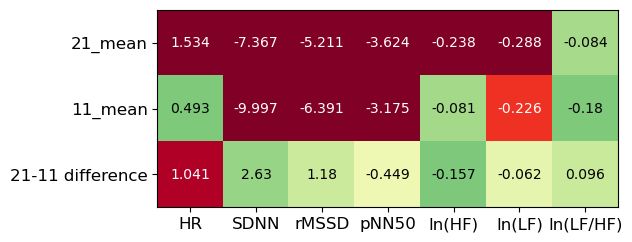

In [13]:
group_1 = 21
group_2 = 11
excel_path = "./resources/data/combined/Data_All_final_1231.xlsx"

df = pd.read_excel(excel_path, sheet_name="step{}_{}".format(group_1, group_2))  # 画图时需要

df["ln(HF)"] = df["HF"].apply(np.log)
df["ln(LF)"] = df["LF"].apply(np.log)
df["ln(LF/HF)"] = df["LF/HF"].apply(np.log)

hrv_variable_list = ["HR", "SDNN", "rMSSD", "pNN50", "ln(HF)", "ln(LF)", "ln(LF/HF)"]
r_squre_list = []

# 对rPPG的数据进行筛选: 保留pNN50>0，并去除residual为outlier的row
criterion_column = "Valid Ratio"
df_threshold = df[df["pNN50"] > 0]
df_residual = compute_threshold(df_threshold)
index = np.array(df_residual.index).tolist()
df_validation = df_threshold.loc[index, :]
df_validation["residual"] = df_residual["residual"]

df_validation, _ = get_outliers_PPG(df_validation, hrv_variable_list)

# 计算同一个人同一个点的结束/开始
df = df_validation.copy()
hrv_variable_index = ["{}".format(i) for i in hrv_variable_list]  # remote PPG
hrv_difference_index = ["{}_difference".format(i) for i in hrv_variable_list]
ref_list = df.loc[:, "No-Step"].tolist()
df.loc[:, hrv_difference_index] = np.nan

for row in df.index:
    no_step = "-".join(df.loc[row, "No-Step"].split("-")[:-1])
    if no_step+"-0" in ref_list:
        start = 0
    else:
        start = -1

    temp_list = []
    for ind in range(0, 20):
        if no_step+"-"+str(ind) in ref_list:
            temp_list.append(ind)
    end = max(temp_list)

    if end > start > -1:  # 说明这个人的数据是可用的（开头是第0段，有结尾，且开头≠结尾）
        end_index = df[df["No-Step"] == no_step+"-"+str(end)].index[0]  # 如果有多个重复行，取第一个的下标
        start_index = df[df["No-Step"] == no_step+"-"+str(start)].index[0]  # 如果有多个重复行，取第一个的下标
        # df.loc[row, hrv_difference_index] = (100*(df.loc[end_index, hrv_variable_index]/df.loc[start_index, hrv_variable_index]).astype('float').apply(np.log)).copy().values.tolist()
        df.loc[row, hrv_difference_index] = (df.loc[end_index, hrv_variable_index]-df.loc[start_index, hrv_variable_index]).astype('float').copy().values.tolist()

df_seq0 = df[df["Seq"] == 0]
df_seq0, _ = get_outliers_PPG(df_seq0, hrv_difference_index)
single_ROI_PPG(df_seq0)


upper bound:  13.56398826204493
HR_difference	-0.213	0.564
SDNN_difference	8.789	0.0
rMSSD_difference	5.22	0.003
pNN50_difference	2.362	0.045
ln(HF)_difference	0.046	0.602
ln(LF)_difference	0.146	0.301
ln(LF/HF)_difference	0.135	0.341

[[  0.27684256  -1.92090343  -0.61223717  -0.62629737  -0.0228063
   -0.10782488  -0.08501859]
 [  0.49001217 -10.70979752  -5.83226724  -2.98792751  -0.06859258
   -0.2535135   -0.21996649]
 [ -0.21316961   8.78889409   5.22003007   2.36163014   0.04578629
    0.14568862   0.13494791]]
[[2.53604808e-01 2.29019503e-01 5.61640248e-01 3.96362038e-01
  6.76312409e-01 2.69001314e-01 3.80392249e-01]
 [8.66033911e-02 3.86840775e-07 5.47403737e-05 1.71009376e-03
  3.24499749e-01 1.61097879e-02 3.82022761e-02]
 [5.63835731e-01 4.14861477e-04 2.50184867e-03 4.50772183e-02
  6.02202379e-01 3.01158503e-01 3.40505191e-01]]


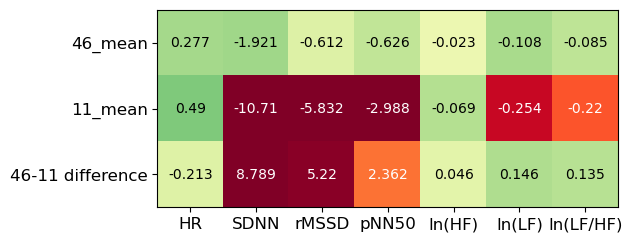

In [14]:
group_1 = 46
group_2 = 11
excel_path = "./resources/data/combined/Data_All_final_1231.xlsx"


df = pd.read_excel(excel_path, sheet_name="step{}_{}".format(group_1, group_2))  # 画图时需要

df["ln(HF)"] = df["HF"].apply(np.log)
df["ln(LF)"] = df["LF"].apply(np.log)
df["ln(LF/HF)"] = df["LF/HF"].apply(np.log)

hrv_variable_list = ["HR", "SDNN", "rMSSD", "pNN50", "ln(HF)", "ln(LF)", "ln(LF/HF)"]
r_squre_list = []

# 对rPPG的数据进行筛选: 保留pNN50>0，并去除residual为outlier的row
criterion_column = "Valid Ratio"
df_threshold = df[df["pNN50"] > 0]
df_residual = compute_threshold(df_threshold)
index = np.array(df_residual.index).tolist()
df_validation = df_threshold.loc[index, :]
df_validation["residual"] = df_residual["residual"]

df_validation, _ = get_outliers_PPG(df_validation, hrv_variable_list)

# 计算同一个人同一个点的结束/开始
df = df_validation.copy()
hrv_variable_index = ["{}".format(i) for i in hrv_variable_list]  # remote PPG
hrv_difference_index = ["{}_difference".format(i) for i in hrv_variable_list]
ref_list = df.loc[:, "No-Step"].tolist()
df.loc[:, hrv_difference_index] = np.nan

for row in df.index:
    no_step = "-".join(df.loc[row, "No-Step"].split("-")[:-1])
    if no_step+"-0" in ref_list:
        start = 0
    else:
        start = -1

    temp_list = []
    for ind in range(0, 20):
        if no_step+"-"+str(ind) in ref_list:
            temp_list.append(ind)
    end = max(temp_list)

    if end > start > -1:  # 说明这个人的数据是可用的（开头是第0段，有结尾，且开头≠结尾）
        end_index = df[df["No-Step"] == no_step+"-"+str(end)].index[0]  # 如果有多个重复行，取第一个的下标
        start_index = df[df["No-Step"] == no_step+"-"+str(start)].index[0]  # 如果有多个重复行，取第一个的下标
        # df.loc[row, hrv_difference_index] = (100*(df.loc[end_index, hrv_variable_index]/df.loc[start_index, hrv_variable_index]).astype('float').apply(np.log)).copy().values.tolist()
        df.loc[row, hrv_difference_index] = (df.loc[end_index, hrv_variable_index]-df.loc[start_index, hrv_variable_index]).astype('float').copy().values.tolist()

# if save:
#     df.to_excel(save_path, index=False)
# if plot:
df_seq0 = df[df["Seq"] == 0]
df_seq0, _ = get_outliers_PPG(df_seq0, hrv_difference_index)
single_ROI_PPG(df_seq0)


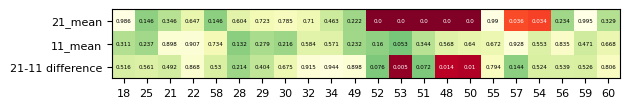

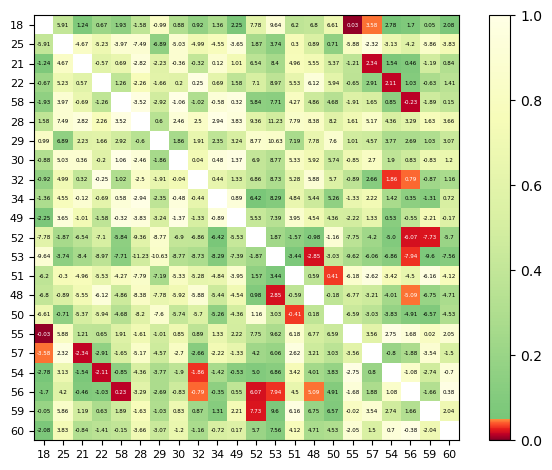

In [15]:

excel_path = "./resources/data/combined/Data_All_final_1231.xlsx"
group_1 = 21
group_2 = 11


df = pd.read_excel(excel_path, sheet_name="step{}_{}".format(group_1, group_2))  # 画图时使用

df = compute_ratio(df)

df_seq0 = df[df["Seq"] == 0]
single_ROI(df_seq0)
df_new = draw_heatmap(df_seq0)

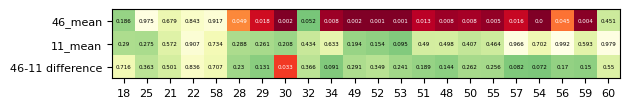

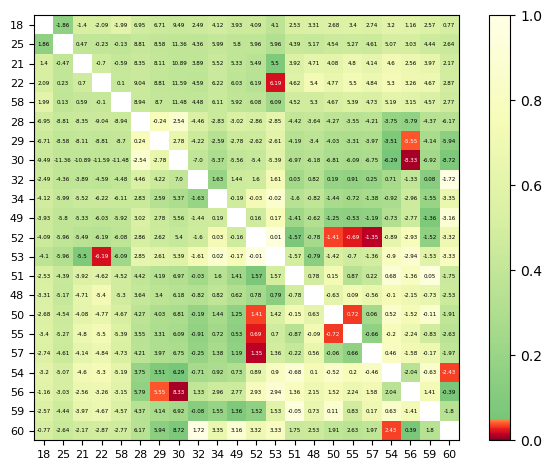

In [16]:

group_1 = 46
group_2 = 11

df = pd.read_excel(excel_path, sheet_name="step{}_{}".format(group_1, group_2))  # 画图时使用

df = compute_ratio(df)

df_seq0 = df[df["Seq"] == 0]
single_ROI(df_seq0)
df_new = draw_heatmap(df_seq0)